In [3]:
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import numpy as np
import torch 
import torch.nn as nn 
import torch.nn.functional as F

In [4]:
# calculate MAPE
def mean_absolute_percentage_error(real, predict):
    res = 0
    count = 0
    for i in range(len(real)):
        if real[i] != 0:
            res += abs((predict[i]-real[i])/real[i])
            count += 1
    return res/count


# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):

    n_vars = 1 if type(data) is list else data.shape[1]

    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j + 1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j + 1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j + 1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [101]:
# load dataset
'''
header = 0: 排除第一行数据； header = -1: 包含第一行数据；
index_col=0：排除第一列数据；index_col=-1：包含第一列数据；
'''
dataset = read_csv('power.csv', header=0, index_col=0)
values = dataset.values
# integer encode direction
# encoder = LabelEncoder()
# values[:, 4] = encoder.fit_transform(values[:, 4])
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1)).fit(values)
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[5,6,7]], axis=1, inplace=True)
print(reframed.head())

# split into train and test sets
values = reframed.values
n_train_hours = 365 * 24
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]


# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)
print(train_X.shape[1],train_X.shape[2])
print(train_X[0:5])

   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)   var1(t)
1   0.423837   0.718447       0.80       0.23  0.404007
2   0.404007   0.718447       0.87       0.15  0.401561
3   0.401561   0.718447       0.87       0.15  0.385192
4   0.385192   0.718447       0.80       0.15  0.410957
5   0.410957   0.718447       0.80       0.15  0.419180
(8760, 1, 4) (8760,) (8735, 1, 4) (8735,)
1 4
[[[0.42383665 0.7184467  0.8        0.23      ]]

 [[0.404007   0.7184467  0.87       0.15      ]]

 [[0.40156126 0.7184467  0.87       0.15      ]]

 [[0.38519195 0.7184467  0.8        0.15      ]]

 [[0.41095704 0.7184467  0.8        0.15      ]]]


In [20]:
plt_data = dataset
plt_data[0:5]
plt_power = plt_data.iloc[:,[0]]
plt_tem = plt_data.iloc[:,[1]]
plt_hum = plt_data.iloc[:,[2]]
plt_spd = plt_data.iloc[:,[-1]]


729
729


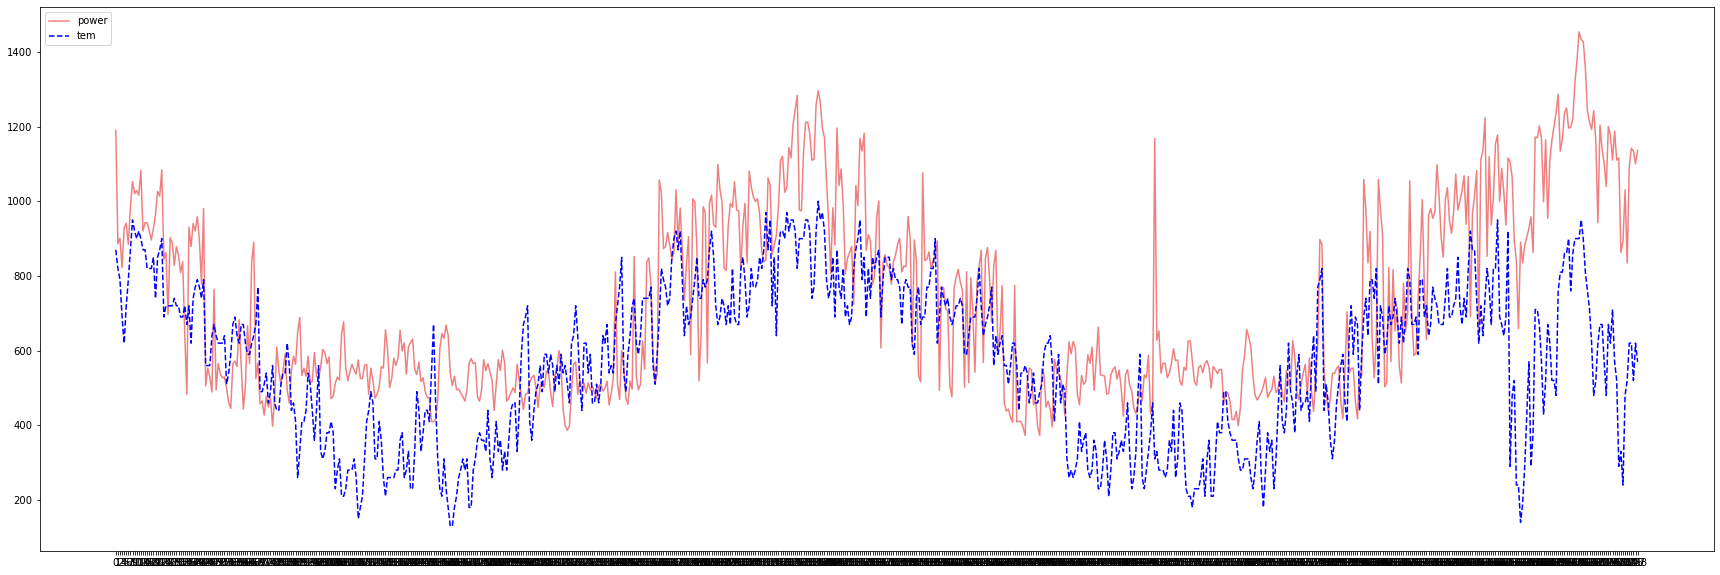

In [91]:
plt_power.squeeze()
plt_tem.squeeze()
p2 = np.array(plt_power)
p2.tolist()
ptem = np.array(plt_tem)
ptem.tolist()
p3 =[]
p4 = []
p3 = [p2[i+12] for i in range(len(p2)) if i%24==0]
p4 = [ptem[i+12]*1000 for i in range(len(ptem)) if i%24==0]
print(len(p3))
print(len(p4))

plt.figure(figsize=(30,10))
plt.plot(range(1,730),p3,label='power',color='#F08080')
plt.plot(range(1,730),p4,label='tem',color='blue',linestyle='--')

_xtick_labels = ["{}".format(i) for i in range(730)]

plt.xticks(range(1,730),_xtick_labels)

plt.legend(loc='upper left')
plt.savefig('power2.png')
plt.show()


In [94]:
class Model(nn.Module):
    def __init__(self):
        super(Model,self).__init__()
        self.fc1 = nn.Linear(4,100)
        self.fc2 = nn.Linear(100,256)
        self.fc3 = nn.Linear(256,512)
        self.fc4 = nn.Linear(512,128)
        self.fc5 = nn.Linear(128,1)
        
    
    def forward(self,x):
        out = self.fc1(x)
        out = F.relu(out)
        out = self.fc2(out)
        out = F.relu(out)
        out = self.fc3(out)
        out = F.relu(out)
        out = self.fc4(out)
        out = F.relu(out)
        out = self.fc5(out)
        return out

model = Model()
#setting
learing_rate = 0.05
epochs = 500
optimizer = torch.optim.Adam(model.parameters(),lr=learing_rate)
# optimizer = torch.optim.Adagrad(torch.nn.parameter(),lr=0.01)
criterion = nn.MSELoss()

In [93]:
train_X = torch.from_numpy(train_X)
train_y =torch.from_numpy(train_y)
test_X = torch.from_numpy(test_X)
test_y= torch.from_numpy(test_y)

In [95]:
for epoch in range(epochs):
    y_pred = model(train_X)
    y2_pred = y_pred.squeeze()
    loss = criterion(y2_pred,train_y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    model.eval()
    with torch.no_grad():
        y_dlr_pred = model(test_X)
        y3_pred = y_dlr_pred.squeeze()
        testloss = criterion(y3_pred,test_y)
    if(epoch+1)%50==0:
        print("loss: {:2f} test loss: {:2f}".format(loss.item(),testloss.item()))


loss: 0.006937 test loss: 0.013264
loss: 0.003196 test loss: 0.005674
loss: 0.003056 test loss: 0.005376
loss: 0.002792 test loss: 0.004413
loss: 0.002933 test loss: 0.004873
loss: 0.002653 test loss: 0.004172
loss: 0.002657 test loss: 0.004109
loss: 0.002812 test loss: 0.004170
loss: 0.002621 test loss: 0.004145
loss: 0.002692 test loss: 0.004218


In [96]:
mape = mean_absolute_percentage_error(y3_pred, test_y)
print('Test mape: %.3f' % mape)


Test mape: 0.121


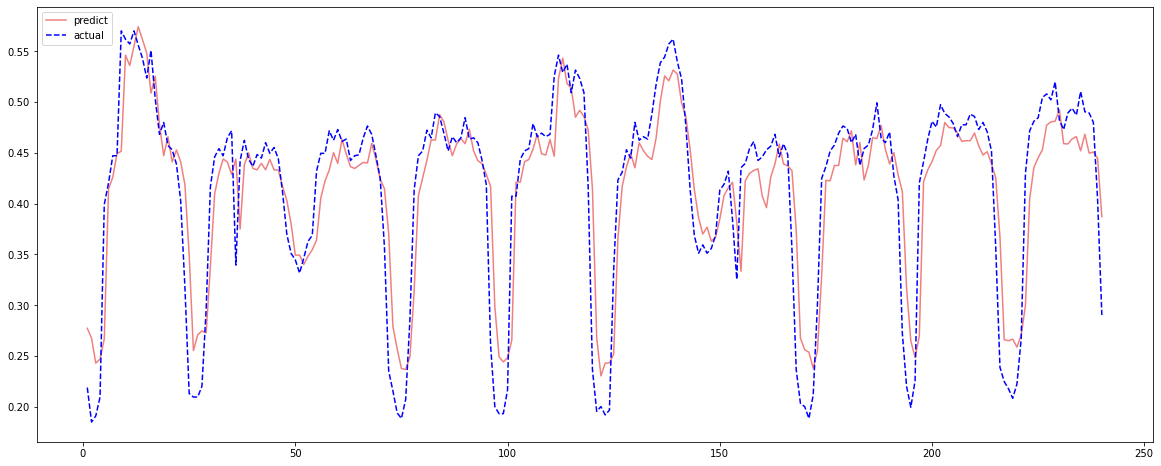

In [97]:
import matplotlib.pyplot as plt
x = range(1,241)
plt.figure(figsize=(20,8))
plt.plot(x,y3_pred[:240],label='predict',color='#F08080')
plt.plot(x,test_y[:240],label='actual',color='blue',linestyle='--')


plt.legend(loc='upper left')
plt.savefig('bp.png')
plt.show()
